# Histopathologic Cancer Detection

This project is based on the Kaggle competition "Histopathologic Cancer Detection". It is a binary image classification task where the goal is to identify metastatic cancer in 96x96 pixel histopathologic image patches.

## Dataset Overview

- Image size: 96 x 96 pixels, RGB
- Format: `.tif`
- Label file: `train_labels.csv`
  - `id`: Image name (without extension)
  - `label`: Cancer presence (1 = cancer, 0 = no cancer)
- Directories:
  - `train/`: Labeled training images
  - `test/`: Unlabeled test images


In [1]:
import pandas as pd
import os
from PIL import Image

project_root = r"C:\Users\xuluj\Documents\histopathologic-cancer-detection"
labels_path = os.path.join(project_root, "train_labels.csv")
labels = pd.read_csv(labels_path)

sample_id = labels.iloc[0]['id']
img_path = os.path.join(project_root, "train", f"{sample_id}.tif")

img = Image.open(img_path)
img.show()


## Class Distribution

Before building models, it is important to understand whether the dataset is balanced. Here we examine the distribution of cancer (1) and non-cancer (0) samples in the training set.


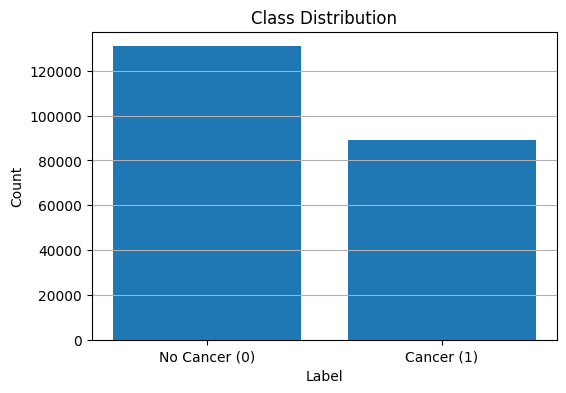

In [2]:
import matplotlib.pyplot as plt

class_counts = labels['label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1], ["No Cancer (0)", "Cancer (1)"])
plt.grid(axis="y")
plt.show()


## Sample Images by Class

Below we visualize a few example images from each class. This helps us understand the visual characteristics of cancerous and non-cancerous samples.


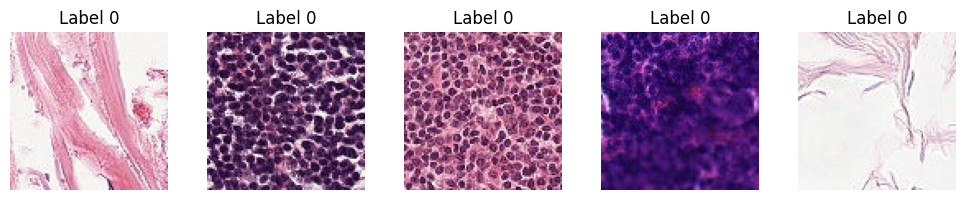

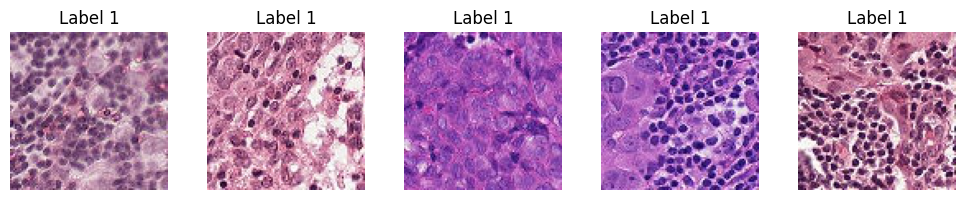

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_sample_images(df, label_value, project_root, num_samples=5):
    sample_ids = df[df['label'] == label_value]['id'].sample(num_samples, random_state=42)
    plt.figure(figsize=(num_samples * 2, 2))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(project_root, "train", f"{img_id}.tif")
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Label {label_value}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(labels, 0, project_root)
plot_sample_images(labels, 1, project_root)


## Grayscale Histogram Analysis

To further explore image differences between classes, we convert a few images to grayscale and plot their pixel intensity histograms. This may help identify potential visual patterns useful for classification.


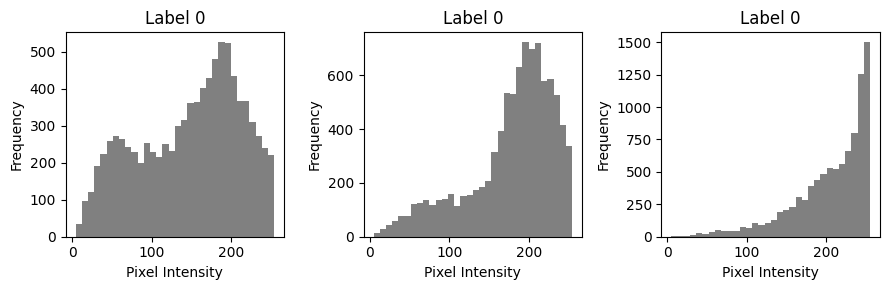

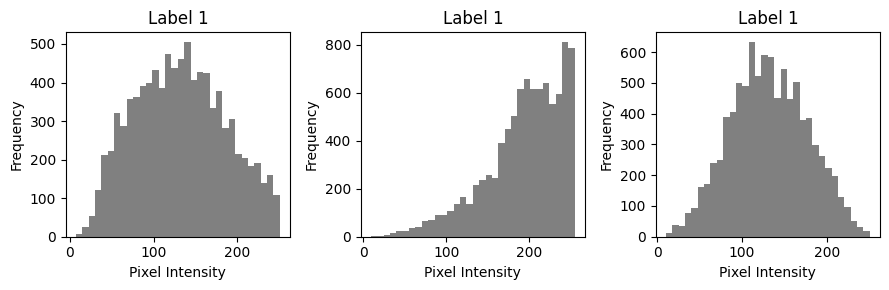

In [4]:
import numpy as np

def plot_grayscale_histograms(df, label_value, project_root, num_samples=3):
    sample_ids = df[df['label'] == label_value]['id'].sample(num_samples, random_state=0)
    plt.figure(figsize=(num_samples * 3, 3))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(project_root, "train", f"{img_id}.tif")
        img = Image.open(img_path).convert("L")
        img_array = np.array(img).flatten()
        plt.subplot(1, num_samples, i + 1)
        plt.hist(img_array, bins=32, color='gray')
        plt.title(f"Label {label_value}")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_grayscale_histograms(labels, 0, project_root)
plot_grayscale_histograms(labels, 1, project_root)


## Data Preprocessing and Train/Validation Split

To prepare the data for model training, we define a preprocessing pipeline and split the dataset into training and validation sets. Images are resized and normalized. This step also helps mitigate data leakage and provides a validation set for performance monitoring.


In [5]:
from torchvision import transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.ToTensor()
])

train_df, val_df = train_test_split(labels, test_size=0.1, stratify=labels['label'], random_state=42)


## Custom PyTorch Dataset

We define a custom PyTorch `Dataset` class to load images and labels from the CSV file and image directory. This class will be used with a `DataLoader` to efficiently feed data during training.


In [6]:
from torch.utils.data import Dataset
from PIL import Image

class HistopathologyDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.loc[idx, 'id']
        label = self.dataframe.loc[idx, 'label']
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label


## DataLoaders

We now create PyTorch `DataLoader` objects for the training and validation sets. These will allow efficient mini-batch loading of image data during model training.


In [7]:
from torch.utils.data import DataLoader

train_dataset = HistopathologyDataset(train_df, os.path.join(project_root, "train"), transform=transform)
val_dataset = HistopathologyDataset(val_df, os.path.join(project_root, "train"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


## Baseline CNN Model

We define a simple Convolutional Neural Network (CNN) as our baseline model. It consists of several convolutional and pooling layers, followed by fully connected layers for binary classification.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


## Training Setup

We define the loss function, optimizer, and device configuration. Since this is a binary classification task, we use `BCELoss` with a sigmoid output. The model will be trained using the Adam optimizer.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BaselineCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Training Loop

We train the model using binary cross-entropy loss. The model is evaluated on the validation set after each epoch to monitor performance.


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5):
    import time
    from tqdm import tqdm

    train_loss_list = []
    val_acc_list = []

    torch.backends.cudnn.benchmark = True
    model.train()
    
    total_start = time.time()
    
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_acc = evaluate_model(model, val_loader, device)

        train_loss_list.append(epoch_loss)
        val_acc_list.append(val_acc)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")
    
    total_time = time.time() - total_start
    print(f"\nTotal training time: {total_time:.2f} seconds")

    return train_loss_list, val_acc_list


## Validation Accuracy

After each training epoch, we evaluate the model on the validation set using accuracy as a simple performance metric.


In [11]:
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = (outputs > 0.5).int().squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    model.train()
    return correct / total


## Full Dataset Training

Now that the model has been verified using a small subset, we proceed to train on the full dataset using all available training images. This step aims to build the final version of the model for evaluation and submission.


In [12]:
train_df, val_df = train_test_split(labels, test_size=0.1, stratify=labels['label'], random_state=42)

train_dataset = HistopathologyDataset(train_df, os.path.join(project_root, "train"), transform=transform)
val_dataset = HistopathologyDataset(val_df, os.path.join(project_root, "train"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

model = BaselineCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)


Epoch 1/5: 100%|██████████| 3095/3095 [14:24<00:00,  3.58it/s]


Epoch 1/5, Loss: 0.3904, Val Acc: 0.8303, Time: 952.78s


Epoch 2/5: 100%|██████████| 3095/3095 [14:00<00:00,  3.68it/s]


Epoch 2/5, Loss: 0.2976, Val Acc: 0.8831, Time: 926.74s


Epoch 3/5: 100%|██████████| 3095/3095 [14:05<00:00,  3.66it/s]


Epoch 3/5, Loss: 0.2521, Val Acc: 0.9062, Time: 931.79s


Epoch 4/5: 100%|██████████| 3095/3095 [14:04<00:00,  3.66it/s]


Epoch 4/5, Loss: 0.2235, Val Acc: 0.9068, Time: 931.54s


Epoch 5/5: 100%|██████████| 3095/3095 [14:41<00:00,  3.51it/s]


Epoch 5/5, Loss: 0.2014, Val Acc: 0.9106, Time: 969.52s

Total training time: 4712.36 seconds


## Training Curve Visualization

To better understand how the model learned during training, we plot the training loss and validation accuracy over epochs.


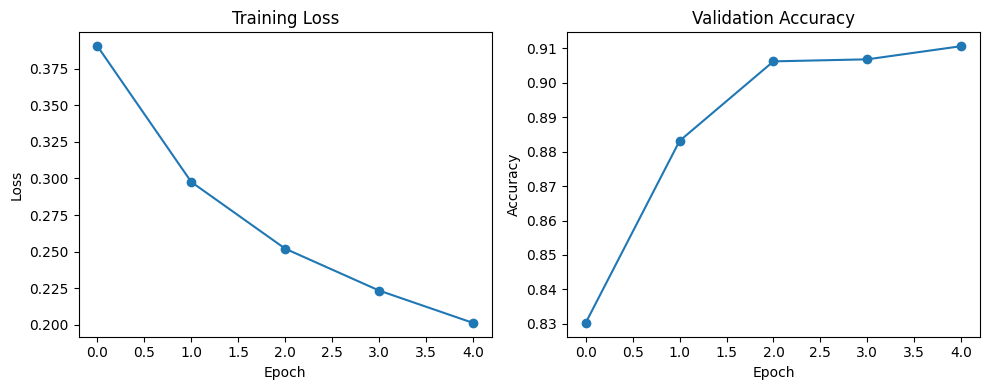

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_acc, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


## Save Trained Model

We save the trained model's weights to disk. This allows us to reuse the model later for inference and Kaggle submission without retraining.


In [14]:
import os

output_dir = os.path.join(project_root, "outputs")
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, "baseline_model.pth")
torch.save(model.state_dict(), model_path)


## Generate Predictions and Submission File

We use the trained model to predict cancer probabilities on the test dataset and generate a submission file in the required Kaggle format.


In [16]:
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
from tqdm import tqdm

class TestDataset(Dataset):
    def __init__(self, image_ids, image_dir, transform=None):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.tif")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_id

test_dir = os.path.join(project_root, "test")
test_ids = [f[:-4] for f in os.listdir(test_dir) if f.endswith(".tif")]

test_dataset = TestDataset(test_ids, test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model.load_state_dict(torch.load(model_path))
model.eval()

submission = []

with torch.no_grad():
    for inputs, img_ids in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
        for img_id, prob in zip(img_ids, outputs):
            submission.append([img_id, prob])

submission_df = pd.DataFrame(submission, columns=["id", "label"])
submission_path = os.path.join(output_dir, "submission.csv")
submission_df.to_csv(submission_path, index=False)


C:\Users\xuluj\AppData\Local\Temp\ipykernel_771448\240488017.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Predicting: 1